### Assuming user intend to interact with IRT via following 3 schemes:
**Scheme 1.** Using all available defaults.

**Scheme 2.** Changing some values and passing new vals to model params.

**Scheme 3.** User bringing in all initializer objects nad passing corresponding object declarations to model_params.

#### Building onto saved dataframe,  following  function appends/extends new records to existing dataset using 'n' bernouli trials.

In [1]:
import pandas as pd
import numpy as np
num_sim_users = 100
num_sim_items = 3
print('# of sim user:',num_sim_users,'\n# of sim items:',num_sim_items)

df_cols = ['user','questions', 'response']

def add_data(array, trials_per_user):
    array_li= array.tolist()#list of tuples
    dock_list=list()#holds tuples generated from trials
    for u, i, prob in array_li:
        success_failure_arr = np.random.binomial(1, prob, trials_per_user)
        
        for resp in success_failure_arr:
            dock_list.append([u,i, resp])
        
    array_li+=dock_list
    return np.array(array_li)

c_probs= pd.read_csv('simulated_data_c_probs.csv')
df_mat = add_data(c_probs.values, trials_per_user=10)
df_sim = pd.DataFrame(df_mat, columns=df_cols)
print('Extended df size:', df_sim.shape)

# of sim user: 100 
# of sim items: 3
Extended df size: (3300, 3)


In [2]:
df_sim['response']=df_sim['response'].apply(lambda x: int(np.round(x)))
df_sim.head(3)

,user,questions,response
0,92.0,0.0,1
1,86.0,2.0,1
2,57.0,1.0,1


### A GeneralisedIrtModel class defines a keras model with following two parameterization schemes for 1PL:
**Scheme 1.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * a_j= discrimination parameter of j-th question
        * c_j= pseudo guessing parameter of j-th question
    
**Scheme 2.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[alpha_j + lamda_j*t_i]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * `lamda_j / a_j`= discrimination parameter of j-th question
        * alpha_j= -lam_j*b_j.
        * c_j = pseudo guessing parameter of j-th question

        



#### Now using  dataset  from above, train a keras 1/2/3PL proxy models model using an mlsquare adapter.

In [3]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_sim[df_cols[:-1]], df_sim[df_cols[-1]], test_size=0.05)

x_train_user = to_categorical(xtrain['user'], num_classes=num_sim_users)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of simulated x_train_user:', x_train_user.shape,'\nshape of simulated  x_train_questions:', x_train_questions.shape,
      '\nshape of simulated  y_train:',y_train.shape)

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

shape of simulated x_train_user: (3135, 100) 
shape of simulated  x_train_questions: (3135, 3) 
shape of simulated  y_train: (3135,)


#### View regsitered IRT proxy models & adapters from mlsquare registry

In [4]:
from mlsquare import registry
reg= registry.data
reg

2020-01-09 18:31:02,578	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-01-09_18-31-02_11087/logs.
2020-01-09 18:31:02,714	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:47720 to respond...
2020-01-09 18:31:02,845	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:23229 to respond...
2020-01-09 18:31:02,853	INFO services.py:760 -- Starting Redis shard with 20.0 GB max memory.
2020-01-09 18:31:02,898	INFO services.py:1384 -- Starting the Plasma object store with 1.0 GB memory using /dev/shm.


{('sklearn',
  'TruncatedSVD'): {'default': [<mlsquare.architectures.sklearn.SVD at 0x7f8a5170b668>,
   mlsquare.adapters.sklearn.SklearnTfTransformer]},
 ('sklearn',
  'LogisticRegression'): {'default': [<mlsquare.architectures.sklearn.LogisticRegression at 0x7f8a5170bb38>,
   mlsquare.adapters.sklearn.SklearnKerasClassifier]},
 ('sklearn',
  'LinearRegression'): {'default': [<mlsquare.architectures.sklearn.LinearRegression at 0x7f8a5170bcf8>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'Ridge'): {'default': [<mlsquare.architectures.sklearn.Ridge at 0x7f8a5170beb8>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'Lasso'): {'default': [<mlsquare.architectures.sklearn.Lasso at 0x7f8a517290b8>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'ElasticNet'): {'default': [<mlsquare.architectures.sklearn.ElasticNet at 0x7f8a51729278>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'LinearSVC'): {'defaul

### Scheme 1.  Using available defaults

#### Doping Rasch(1PL) primal model class & performing a fit.

In [5]:
from mlsquare import dope

In [6]:
from mlsquare.embibe.irt import rasch

primal1= rasch()
primal1

rasch(Hessian=True, IRT_param=True, constraint='NULL', control=[], data=None,
      na_action='NULL', start_val='NULL')

In [7]:
model1pl= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [8]:
model1pl.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40)


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Training on : 3135 samples for : 40 epochs has completed in : 2.551 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [9]:
model1pl.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait/ability (Dense)    (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

#### Obtaining underlying trained Rasch(1pl) parameters from doped model

In [10]:
model1pl.coefficients()

{'difficulty_level': array([[0.09145481],
        [0.17275578],
        [0.4433803 ]], dtype=float32), 'disc_param': array([[1.],
        [1.],
        [1.]], dtype=float32), 'guessing_param': array([[0.],
        [0.],
        [0.]], dtype=float32)}

* **Train Vs. Validation loss curves for simulated dataset**

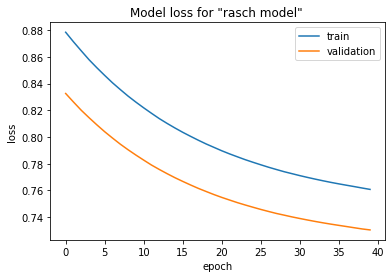

In [11]:
model1pl.plot()

* **Following are the available default configs(backend-distributions)**

In [12]:
model1pl.proxy_model.default_backend_dist_params

{'backend': {'keras': {'distrib': {'normal': {'mean': 0, 'stddev': 0},
    'uniform': {'minval': 0, 'maxval': 0, 'distrib': 'uniform'}}},
  'pytorch': {'distrib': {'normal': {'mean': 0, 'stddev': 0},
    'uniform': {'minval': 0, 'maxval': 0, 'distrib': 'uniform'}}}}}

* **For existing configs, following is the updated dictionary(containing initializer objects as a result of `get_initializers()`) taking reference configs from `default_backend_dist_params` dictionary above.**

In [13]:
model1pl.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {},
  'kernel': <keras.initializers.RandomNormal at 0x7f8a5145a828>},
 'diff_params': {'units': 1,
  'kernel_params': {},
  'kernel': <keras.initializers.RandomNormal at 0x7f8a5145a860>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f8a5145a8d0>},
 'guess_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f8a5145a908>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

* Model is fit with available defaults, since No params are passed in `model.fit()`

### Scheme 2. Changing some values and passing new vals to model params.

* Customizing some initializers for new training exp.
    * kernel_params of select layer of-- latent_trait, difficulty_level, disc_params, guess_params

**2.1 Updating `ability_params` layer's kernel initilizer to `keras:uniform:defaults`**

In [14]:
params_ = {'ability_params': {'units':1, 'kernel_params': {'distrib':'uniform'}}}
params_

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}}}

In [15]:
model1pl_2s1= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [16]:
model1pl_2s1.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.365 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [17]:
#Overall model_params with kernel_params & kernels after updation 1.1
model1pl.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f8a4efce0f0>},
 'diff_params': {'units': 1,
  'kernel_params': {},
  'kernel': <keras.initializers.RandomNormal at 0x7f8a4efce080>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f8a4efce1d0>},
 'guess_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f8a4efce208>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

**2.2 Updating `difficulty_level` layer's kernel initilizer to `keras:uniform:minval:-2`**

In [18]:
params_ = {'diff_params': {'units':1, 'kernel_params': {'distrib':'uniform', 'minval':-2}}}
params_

{'diff_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -2}}}

In [19]:
model1pl_2s2= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [20]:
model1pl_2s2.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.334 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [21]:
#Overall model_params with kernel_params & kernels after updation 1.2
model1pl_2s2.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f8a30737a90>},
 'diff_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -2},
  'kernel': <keras.initializers.RandomUniform at 0x7f8a307372b0>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f8a307376a0>},
 'guess_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f8a30737048>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

**2.3 Updating Multiple layer(All) initializer at once--**
* `latent_trait`->`keras:uniform:defaults`
* `difficulty_level'`->`keras:uniform:defaults`
* `'disc_params`->`keras:normal:stddev:0`
* `guess_params`->`keras:normal:stddev:0`

In [22]:
params_ = {'ability_params': {'units': 1, 'kernel_params':{'distrib': 'uniform'}},
 'diff_params': {'units': 1,'kernel_params': {'distrib': 'uniform'}},
 'disc_params':{'units': 1, 'kernel_params': {'stddev': 0},'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel_params': {'stddev': 0}, 'train': False, 'act': 'linear','slip': 0}}
params_

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [23]:
model1pl_2s3= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [24]:
model1pl_2s3.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.635 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [25]:
model1pl_2s3.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f8a30746e80>},
 'diff_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f8a307469b0>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f8a61fbfda0>},
 'guess_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomNormal at 0x7f8a3073feb8>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

### Scheme 3. User bringing in all initializer objects nad passing corresponding object declarations to model_params.

**3.1 Customizing all layers' kernel in model_params through object declaration (Total scheme 3)**

In [26]:
from keras import initializers

In [27]:
params_1 = {'ability_params': {'units': 1,'kernel':initializers.RandomNormal(mean=1, stddev=0.5)},
 'diff_params': {'units': 1,'kernel':initializers.RandomUniform(minval=-3.5, maxval=-2.5)},
 'disc_params':{'units': 1, 'kernel':initializers.RandomNormal(mean=0.5, stddev=1.5),'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel':initializers.RandomUniform(minval=-3.5, maxval=-1.5), 'train': False, 'act': 'linear','slip': 0}}
params_1

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f89e06eb550>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e06eb588>},
 'disc_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f89e06eb5c0>,
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e06eb5f8>,
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [28]:
model1pl_3s1= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [29]:
model1pl_3s1.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_1)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.663 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [30]:
model1pl_3s1.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f89e06eb550>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e06eb588>},
 'disc_params': {'units': 1,
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f89e06eb5c0>},
 'guess_params': {'units': 1,
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e06eb5f8>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

**3.2 Customizing some layers' kernel in model_params through object declaration(`{'kernel':object_dec}`) and remaining through use of available defaults(`{kernel_params': {'distrib': 'uniform'}})`,-- a mix of scheme 2 & 3.**

In [31]:
params_2 = {'ability_params': {'units': 1,'kernel':initializers.RandomNormal(mean=1, stddev=0.5)},
 'diff_params': {'units': 1,'kernel':initializers.RandomUniform(minval=-3.5, maxval=-2.5)},
 'disc_params':{'units': 1, 'kernel_params': {'distrib': 'uniform', 'minval':-6},'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel':initializers.RandomUniform(minval=-3.5, maxval=-1.5), 'train': False, 'act': 'linear','slip': 0}}
params_2

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f89e02edef0>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf28>},
 'disc_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -6},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf60>,
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [32]:
model1pl_3s2= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [33]:
model1pl_3s2.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_2)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.932 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [34]:
#Overall model_params with kernel_params & kernels after updation 1.1
model1pl_3s2.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f89e02edef0>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf28>},
 'disc_params': {'units': 1,
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02ed668>,
  'kernel_params': {'distrib': 'uniform', 'minval': -6}},
 'guess_params': {'units': 1,
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf60>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

### *** Easing updation of kernel params Or Kernel; ignoring the mention of other key:value pairs at same level of model_param dictionary during updation. (So to infer, preventing dictionary Overwrite).

For instance Enable working with-- params_ = `{'guess_params': {'kernel_params': {'distrib':'uniform', 'minval':-2}}}` NOT `'{guess_params':{'units':1, 'kernel_params':{'distrib':'uniform'}, 'train':False, 'act':'linear', 'slip':0}`

**The model_params updation should happen without modifying unspecified(Or Default model_params)**

**1.1 Following contains the select params-- `{'kernel_params': {'distrib':'uniform'}`,`{'train':True, 'slip':1}` to be updated at layer level.**
* [Not `{'kernel':kernel_object}`]

In [35]:
params_ = {'ability_params': {'kernel_params': {'distrib':'uniform'}},
           'disc_params': {'kernel_params': {'distrib': 'uniform', 'minval':-4}},
          'guess_params': {'train': True}}

* Issues without tap (targeted) model_params update

In [36]:
params_o = {'ability_params': {'units': 1, 'kernel_params':{}},
 'diff_params': {'units': 1,'kernel_params': {'std':0.5}},
 'disc_params':{'units': 1, 'kernel_params': {'stddev': 0},'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel_params': {'stddev': 0}, 'train': False, 'act': 'linear','slip': 0}}
params_o

{'ability_params': {'units': 1, 'kernel_params': {}},
 'diff_params': {'units': 1, 'kernel_params': {'std': 0.5}},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [37]:
#get_params output is overwrritten with ordinary dict update as follows
params_copy= params_o.copy()
params_copy.update(params_)
params_copy

{'ability_params': {'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1, 'kernel_params': {'std': 0.5}},
 'disc_params': {'kernel_params': {'distrib': 'uniform', 'minval': -4}},
 'guess_params': {'train': True}}

* The params_copy is overwritten at places targeted by params dictionary, which amounts to 'keyerror' in architecture's `create_model()` method

**With deep_dict updation is done in targeted manner, unaffecting the rest unspecified defaults.**

In [38]:
from dict_deep import *

def tap_update(params_to_tap, params):
        #li= list()
        for k, v in params.items():
            n_keys= len(v.keys())
            for key, val in v.items():#for iters in range(n_keys):
                li= [k,key]# for key, val in v.items()
                assign = deep_get(params, li)
                deep_set(params_to_tap, li, deep_get(params, li), 
                    accessor=lambda params_to_tap, k: params_to_tap.setdefault(k, dict()))


In [39]:
tap_update(params_o, params_)
params_o

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1, 'kernel_params': {'std': 0.5}},
 'disc_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -4},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': True,
  'act': 'linear',
  'slip': 0}}

In [40]:
from mlsquare import dope
model1pl_4s1= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


* Passing following select params to update model_params & fit.

In [41]:
params_

{'ability_params': {'kernel_params': {'distrib': 'uniform'}},
 'disc_params': {'kernel_params': {'distrib': 'uniform', 'minval': -4}},
 'guess_params': {'train': True}}

In [42]:
model1pl_4s1.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params= params_)


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.771 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [43]:
model1pl_4s1.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89ae693f28>,
  'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf28>},
 'disc_params': {'units': 1,
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomUniform at 0x7f89ae693e80>,
  'kernel_params': {'distrib': 'uniform', 'minval': -4}},
 'guess_params': {'units': 1,
  'train': True,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf60>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

* **Above select update is not agnostic to all key:value pairs, as the logic flow updates/adds `{'kernel':object_dec}` everytime in response to `{'kernel_params':{}}` it obtains as input, and since `{'kernel_params':{}}` is by defalt there(declared) during dope object creation and passed in as `self._model_params` and despite `{'kernel_params':{}}` not being passed in select params at fit it exists because of `deep_set` method by `dict_deep`.**

**1.2 Following contains the select params-- `{'kernel':object declaration}` to be updated at layer level.**

In [44]:
from keras import initializers
params_2 = {'diff_params': {'kernel': initializers.RandomUniform(minval=-2, maxval=-2.5)}}
params_2

{'diff_params': {'kernel': <keras.initializers.RandomUniform at 0x7f89ae26da20>}}

In [45]:
model1pl_5 = dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [46]:
model1pl_5.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_2)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.822 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [47]:
model1pl_5.model.layers[4].get_config()

{'name': 'difficulty_level',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -2, 'maxval': -2.5, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

* Now the `difficulty_level` is updated with passed initializer object.

In [48]:
model1pl_5.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89ae26d908>,
  'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89ae26da20>},
 'disc_params': {'units': 1,
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomUniform at 0x7f89ae26d6a0>,
  'kernel_params': {'distrib': 'uniform', 'minval': -4}},
 'guess_params': {'units': 1,
  'train': True,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf60>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

* **1.3 Passing both `kernel_params` and `kernel` key:vals `{'kernel_params':{}, 'kernel':Object declaration}` as select params.**

In [49]:
params_2= {'diff_params': {'kernel_params':{}, 'kernel': initializers.RandomUniform(minval=-2, maxval=-2.5)}}
params_2

{'diff_params': {'kernel_params': {},
  'kernel': <keras.initializers.RandomUniform at 0x7f89ade325c0>}}

In [50]:
model1pl_5 = dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [51]:
model1pl_5.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_2)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.91 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [52]:
model1pl_5.model.layers[4].get_config()

{'name': 'difficulty_level',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0, 'stddev': 1, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

* Here when user passes different args in `kernel_params` and `kernel` (`{'kernel_params':{}, 'kernel': object_dec}`), model prefers to ignore `'kernel': object_dec` and updates `model_params` with `{'kernel_params':{}}`

In [54]:
model1pl_5.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f89ade32550>,
  'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f89ade32908>,
  'kernel_params': {}},
 'disc_params': {'units': 1,
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomUniform at 0x7f89ade32588>,
  'kernel_params': {'distrib': 'uniform', 'minval': -4}},
 'guess_params': {'units': 1,
  'train': True,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f89e02edf60>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

________________________

### Future works
* Sensitivity to default params